# **Appendix: LangGraph - A Framework for Prompt Engineering**

This chapter, unlike the previous ones, delves into an **advanced version of prompt engineering**, introducing methods for **prompt optimization**. There are various ways to optimize prompts, and among them, we will demonstrate how to use **LangGraph with Solar** to effectively enhance and refine prompts.

The reason for choosing prompt engineering using LangGraph among many advanced techniques is that LangGraph's features enable the integration of a **"human feedback"** process during the prompt extraction stage.

> LangGraph is a visual framework for structuring and optimizing prompts.  
> It maps linguistic elements to functional goals, clarifying how prompt components influence outputs.  
> By organizing prompts into nodes (language elements), edges (relationships), and goals (desired outcomes), LangGraph connects linguistic intuition with technical implementation.  

**What You'll Learn in This Appendix**

- [The core structure and components of LangGraph](#1)

- [How to visualize prompt interactions and their outcomes](#2)

- [A practical example of prompt optimization](#3)

**Set up**

In [ ]:
%%capture
!pip install langgraph langchain_core langchain_openai

In [ ]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain.output_parsers import RegexParser
from langchain_openai import ChatOpenAI
import os

# Retrieve the UPSTAGE_API_KEY variable from the IPython store
%store -r UPSTAGE_API_KEY

try:
    if UPSTAGE_API_KEY:
        print("Success!")
except NameError as ne:
    print(f"Since, {ne}")
    print("Please, insert your API key.")
    UPSTAGE_API_KEY = input("UPSTAGE_API_KEY =")

# Set your API key: 
# UPSTAGE_API_KEY = " " ←- Insert your API key here. 

Success!


In [ ]:
# Initialization
def get_llm(model: str ="solar-pro", temperature: float=0.0, **kwargs: any)-> ChatOpenAI:
    return ChatOpenAI(
        api_key=os.environ["UPSTAGE_API_KEY"],
        base_url="https://api.upstage.ai/v1",
        model=model,
        temperature=temperature,
        **kwargs
    )

parser = RegexParser(
    regex=r"revised prompt:\s*(.+)",
    output_keys=["revised_prompt"]
)

solar = get_llm()

**Set up the State**

In [ ]:
from typing import Annotated, TypedDict
import operator  

# Set up the GraphState
class GraphState(TypedDict):
    """
    A TypedDict class representing the state of the prompt optimization graph.

    Attributes:
        prompt (Annotated[list, operator.add]): List containing the prompts being optimized
        ai_feedback (Annotated[list, operator.add]): List containing AI-generated feedback on prompts
        human_feedback (Annotated[list, operator.add]): List containing human feedback on prompts
    """

    prompt: Annotated[list, operator.add]
    ai_feedback: Annotated[list, operator.add]
    human_feedback: Annotated[list, operator.add]

---

<a id="1"></a>
## **1. Prompt Optimization with LangGraph: 5-Step Process with Solar** 

[Step 1: Analyze the Prompt Given by User](#step1)  

[Step 2: Human Feedback](#step2) 

[Step 3: Test the Prompt](#step3)

[Step 4: Optimize the Prompt](#step4)

[Step 5: Evaluate the Prompt](#step5)

### **1.1 Define the Nodes**

<a id="step1"></a>
- **Step 1: Analyze the Prompt Given by User**

In [ ]:
# 1st node: analyze_prompt
def analyze_prompt(state: GraphState, llm: ChatOpenAI=solar) -> GraphState:
    """
    Analyzes the given prompt and revise it for improvement.

    Args:
        state (GraphState): Current state contains the prompt to analyze
        llm (ChatOpenAI): Language model( Solar with temperature: 0.0 ) used to generate feedback and improvements

    Returns:
        GraphState: Updated state with AI feedback and revised prompt
    """
    latest_prompt = state["prompt"][0]

    print("[ Here is the user's prompt ]")
    print(latest_prompt)

    prompt = PromptTemplate.from_template(
        """
    Your task is to analyze user's prompt. 

    1. Extract the user's intent. And write down a single word focused on 'action ascription'.
    2. Check your output is aligned with the user's intent.   
    3. Suggest me some improvements for the prompt. 
    4. Revise my prompt to ensure it includes two focal elements: examples and ample context within the prompt.
    5. Your output should be within 4 sentences. Format: 
        (1) user's intent:
        (2) some improvement:
        (3) revised prompt: *don't answer to the user's prompt.
        
                                          
    --------> 
    User's prompt: 
    {prompt}
    --------> 
    """)

    chain = prompt | llm | StrOutputParser()

    output = chain.invoke({"prompt": latest_prompt})
    response = f"Here is the feedback generated by AI: \n{output}"

    parsed_response = parser.parse(output)
    revised_prompt = parsed_response["revised_prompt"]

    return {"prompt": [revised_prompt],
            "ai_feedback": [response]}

print("\n\n")

<a id="step2"></a>
- **Step 2: Human Feedback**

In [ ]:
# 2nd node: human
def human_feedback(state: GraphState) -> GraphState:
    """
    Collects feedback from the user.

    Args:
        state (GraphState): Current state of the graph

    Returns:
        GraphState: Update state with human feedback
    """
    print("[ Here is the proposed prompt ] \n", state['prompt'][-1])
    user_input = input("(Press 'q' or 'quit' to quit)")

    return {"human_feedback": [user_input]}

print("\n\n")

<a id="step3"></a>
- **Step 3: Test the Prompt**

In [ ]:
# 3rd node: test_prompt
def test_optimized_prompt(state: GraphState, llm: ChatOpenAI=get_llm(temperature=0.7)) -> GraphState:
    """
    Tests both previous and current prompts, comparing their responses.
    
    Args:
        state (GraphState): Current state containing both prompts
        llm (ChatOpenAI): Language model( Solar with temperature: 0.7 ) used to generate feedback
        
    Returns:
        GraphState: Updated state with comparison of responses
    """
    previous_prompt = state["prompt"][-2]  # Get previous prompt
    current_prompt = state["prompt"][-1]  # Get latest prompt
    
    # Get responses for both prompts
    previous_response = llm.invoke(previous_prompt)
    revised_response = llm.invoke(current_prompt)
    
    # Compare the responses
    comparison_prompt = f"""
    Compare these two responses:
    
    PREVIOUS PROMPT: {previous_prompt}
    PREVIOUS RESPONSE: {previous_response.content}
    
    REVISED PROMPT: {current_prompt}
    REVISED RESPONSE: {revised_response.content}
    
    Please analyze:
    1. Key differences in responses. 
    2. Summarize the differences within 1 sentence.  
    3. tell me which one is better: Previous or Revised?  
    """

    analysis = llm.invoke(comparison_prompt)
    
    return {"ai_feedback": [
        f"Previous Prompt Response:\n{previous_response.content}\n\n"
        f"Revised Prompt Response:\n{revised_response.content}\n\n"
        f"Comparative Analysis:\n{analysis.content}"
    ]}

print("\n\n")

<a id="step4"></a>
- **Step 4: Optimize the Prompt**

In [ ]:
# 4th node: optimize_prompt
def optimize_prompt(state: GraphState, llm: ChatOpenAI=solar) -> GraphState:
    """
    Optimizes the prompt based on your feedback and the user's feedback. 

    Args:
        state (GraphState): Current state contains the prompt, AI feedback(your feedback), and the user's feedback 
        llm (ChatOpenAI): Language model( Solar with temperature: 0.0 ) used to optimize prompt based on feedback

    Returns:
        GraphState: Updated state with optimized prompt
    """
    latest_prompt = state["prompt"][-1]
    latest_ai_feedback = state["ai_feedback"][-1]
    latest_human_feedback = state["human_feedback"][-1]

    if latest_human_feedback == "q" or latest_human_feedback == "quit":
        latest_human_feedback = ""
        return {"prompt": [latest_prompt]}

    prompt = PromptTemplate.from_template(
    """
    Your task is to optimize the user's prompt. Follow these instructions: 

    Here is the prompt before improvement:
    {prompt}

    Here is previous feedback generated by AI:
    {ai_feedback}

    Here is Human's follow-up feedback:
    {human_feedback}

    Write down the improved prompt. Only present the revised prompt without any additional comments. 
    """
    )

    chain = prompt | llm | StrOutputParser()

    response = chain.invoke(
        {
            "prompt": latest_prompt,
            "ai_feedback": latest_ai_feedback,
            "human_feedback": latest_human_feedback,
        }
    )
    return {"prompt": [response]}

print("\n\n")

<a id="step5"></a>
- **Step 5: Evaluate the Prompt**

In [ ]:
# 5th node: evaluate_prompt
def evaluate_prompt(state: GraphState, llm: ChatOpenAI=solar) -> GraphState:
    """
    Evaluates the optimized prompt by comparing it to the previous prompt.

    Args:
        state (GraphState): Current state contains the previous prompt and the optimized prompt
        llm (ChatOpenAI): Language model( Solar with temperature: 0.0 ) used to evaluate the optimized prompt

    Returns:
        GraphState: Updated state with evaluation feedback
    """
    before_optimization_prompt = state["prompt"][-2]
    improved_prompt = state["prompt"][-1]

    prompt = PromptTemplate.from_template(
        """
    Now, let's evaluate the prompt. Follow these instructions: 
    - 1. Comparision : read two prompts carefully and think about the difference between them.  
    previous prompt: {before_optimization_prompt}
    revised prompt: {improved_prompt}

    - 2. Scoring: Give a score between 0 and 1 for 4 criteria. Show your the total score at the end. 
    If yes add 1, else add 0.   
      - 2.1) Is the revised prompt aligned with the user's intent? (yes or no)
      - 2.2) Is the revised prompt able to generate a better output than the previous prompt? (yes or no)
      - 2.3) Is the revised prompt well-structured? (yes or no)
      - 2.4) Is the revised prompt of flexible length? (yes or no) 
    Sum up your score for each criterion: [ ]
       
    - 3. Writedown the justification for your score within 2 sentences. 

    """
    )

    chain = prompt | llm | StrOutputParser()

    response = chain.invoke(
        {
            "before_optimization_prompt": before_optimization_prompt,
            "improved_prompt": improved_prompt,
        }
    )
    return {"ai_feedback": [response]}

# An additional path: CONTINUE 
def should_continue(state: GraphState) -> str:
    """
    Determines whether to continue the optimization loop based on the user's feedback.

    Args:
        state (GraphState): Current state containing the user's feedback

    Returns:
        str: "FINISH" if the user wants to quit, "CONTINUE" otherwise
    """
    latest_human_feedback = state["human_feedback"][-1].strip()
    if latest_human_feedback == "q" or latest_human_feedback == "quit":
        return "FINISH"
    else:
        return "CONTINUE"
    
print("\n\n")

---

<a id="2"></a>
## **2. LangGraph Workflow**

### **2.1 Set up the Graph**

This code sets up a LangGraph workflow for prompt optimization with the following components:

**1. Memory Management**:

   - Uses **`MemorySaver`** for maintaining state across workflow steps

   - Creates a **`StateGraph`** instance for managing prompt optimization states

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, END

memory = MemorySaver()
workflow = StateGraph(GraphState)

<br>  

**2. Node Configuration**:

   - `analyze_prompt`: Analyzes the initial prompt

   - `human`: Handles human feedback loop

   - `optimize_prompt`: Performs prompt optimization

   - `evaluate_prompt`: Evaluates optimization results

In [ ]:
workflow.add_node("analyze_prompt", analyze_prompt)
workflow.add_node("human", human_feedback)
workflow.add_node("test_prompt", test_optimized_prompt)
workflow.add_node("optimize_prompt", optimize_prompt)
workflow.add_node("evaluate_prompt", evaluate_prompt)

<br>  

**3. Edge Configuration**:

   - **Linear flow** from analyze_prompt to human

   - **Conditional branching** from human based on should_continue function

   - **Optimization cycle** between optimize_prompt and evaluate_prompt

   - Final **feedback loop** back to human

In [ ]:
# Add edges for the new flow
workflow.add_edge("analyze_prompt", "human")
workflow.add_edge("human", "test_prompt")
workflow.add_edge("test_prompt", "optimize_prompt")
workflow.add_edge("optimize_prompt", "evaluate_prompt")
workflow.add_conditional_edges(
    "evaluate_prompt",
    should_continue,
    {
        "CONTINUE": "human",
        "FINISH": END
    }
)

<br>  

**4. Graph Compilation**:

   - Sets analyze_prompt as **entry point**
   
   - Compiles with memory **checkpointing**

In [ ]:
workflow.set_entry_point("analyze_prompt")
graph = workflow.compile(checkpointer=memory)

print("\n\n")

### **2.2 Visualize the Graph**

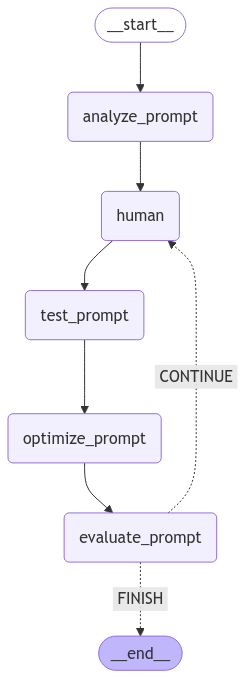

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

print("\n\n")

---

<a id="3"></a>
## **3. Example**

**Example #1: Execute the LangGraph Workflow for Prompt Optimization.**

This code initializes and runs a LangGraph workflow to optimize an initial prompt through multiple iterations.
The workflow streams events and updates for each step of the optimization process.

***Parameters:**

- `recursion_limit (int)`: The maximum number of recursive iterations (default: 100).

- `thread_id (str)`: A unique identifier for the workflow execution.

- `initial_prompt (str)`: The starting prompt template to be optimized.

- `stream_mode (str)`: The mode for streaming graph execution updates.

**Run the Graph**

In [ ]:
import uuid
from langchain_core.runnables import RunnableConfig

# Configure execution parameters
config = RunnableConfig(
    recursion_limit=100, configurable={"thread_id": str(uuid.uuid4())}
)

initial_prompt = """What is the capital of Seoul?"""


# Initialize graph state with input prompt
inputs = GraphState(prompt=[initial_prompt])

# Execute graph and stream updates
for event in graph.stream(inputs, config, stream_mode="updates"):
    for key, value in event.items():
        print(f"\n[ {key} ]\n")
        if key == "analyze_prompt":
            filtered_values = {k: v for k, v in value.items() if k != "prompt"}
        elif key == "human":
            filtered_values = {k: ("" if v[-1] in ['q', 'quit'] else v[-1]) for k, v in value.items()}
        else:
             filtered_values = value
        for _, v in filtered_values.items():
                if isinstance(v, list):
                    print(f"{v[-1]}")
                else:
                     print(v)
    print("===" * 10, " STEPS ", "===" * 10)

print("\n\n")

[ Here is the user's prompt ]
What is the capital of Seoul?

[ analyze_prompt ]

Here is the feedback generated by AI: 

    (1) user's intent: seek information
    (2) some improvement: clarify that Seoul is a city, not a country, and provide the correct capital for the country it's in
    (3) revised prompt: "Seoul is a city in South Korea. What is the capital of South Korea, and can you give an example of a famous landmark in that city?"
==============================  STEPS  ==============================
[ Here is the proposed prompt ] 
 "Seoul is a city in South Korea. What is the capital of South Korea, and can you give an example of a famous landmark in that city?"

[ human ]


==============================  STEPS  ==============================

[ test_prompt ]

Previous Prompt Response:
Seoul is the capital city of South Korea, so it does not have a capital. However, if you're asking about the capital of the Seoul Special City, it is also Seoul. Is there anything else I can 

**Check out the optimized prompt!**

In [ ]:
snapshot = graph.get_state(config).values
print(f"Initial Prompt Given: \n{snapshot['prompt'][0]}")
print("===" * 20)
print(f"Optimized Prompt: \n{snapshot['prompt'][-1]}")
print("\n\n")

Initial Prompt Given: 
What is the capital of Seoul?
Optimized Prompt: 
"Seoul is a city in South Korea. What is the capital of South Korea, and can you give an example of a famous landmark in that city?"





---

## **4. Full Code of Prompt Optimization with LangGraph**

In [ ]:
import os
from typing import Annotated, TypedDict
import operator
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain.output_parsers import RegexParser
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, END  

# Retrieve the UPSTAGE_API_KEY variable from the IPython store
%store -r UPSTAGE_API_KEY

try:
    if UPSTAGE_API_KEY:
        print("Success!")
except NameError as ne:
    print(f"Since, {ne}")
    print("Please, insert your API key.")
    UPSTAGE_API_KEY = input("UPSTAGE_API_KEY =")

# Set your API key: 
# UPSTAGE_API_KEY = " " ←- Insert your API key here. 

# Initialization
def get_llm(model: str ="solar-pro", temperature: float=0.0, **kwargs: any)-> ChatOpenAI:
    return ChatOpenAI(
        api_key=os.environ["UPSTAGE_API_KEY"],
        base_url="https://api.upstage.ai/v1",
        model=model,
        temperature=temperature,
        **kwargs
    )

parser = RegexParser(
    regex=r"revised prompt:\s*(.+)",
    output_keys=["revised_prompt"]
)
solar = get_llm()

# Set up the GraphState
class GraphState(TypedDict):
    """
    A TypedDict class representing the state of the prompt optimization graph.

    Attributes:
        prompt (Annotated[list, operator.add]): List containing the prompts being optimized
        ai_feedback (Annotated[list, operator.add]): List containing AI-generated feedback on prompts
        human_feedback (Annotated[list, operator.add]): List containing human feedback on prompts
    """

    prompt: Annotated[list, operator.add]
    ai_feedback: Annotated[list, operator.add]
    human_feedback: Annotated[list, operator.add]

# 1st node: analyze_prompt
def analyze_prompt(state: GraphState, llm: ChatOpenAI=solar) -> GraphState:
    """
    Analyzes the given prompt and revise it for improvement.

    Args:
        state (GraphState): Current state contains the prompt to analyze
        llm (ChatOpenAI): Language model used to generate feedback and improvements

    Returns:
        GraphState: Updated state with AI feedback and revised prompt
    """
    latest_prompt = state["prompt"][0]

    print("[ Here is the user's prompt ]")
    print(latest_prompt)

    prompt = PromptTemplate.from_template(
        """
    Your task is to analyze user's prompt. 

    1. Extract the user's intent. And write down a single word focused on 'action ascription'.
    2. Check your output is aligned with the user's intent.   
    3. Suggest me some improvements for the prompt. 
    4. Revise my prompt to ensure it includes two focal elements: examples and ample context within the prompt.
    5. Your output should be within 4 sentences. Format: 
        (1) user's intent:
        (2) some improvement:
        (3) revised prompt: *don't answer to the user's prompt.
        
                                          
    --------> 
    User's prompt: 
    {prompt}
    --------> 
    """)

    chain = prompt | llm | StrOutputParser()

    output = chain.invoke({"prompt": latest_prompt})
    response = f"Here is the feedback generated by AI: \n{output}"

    parsed_response = parser.parse(output)
    revised_prompt = parsed_response["revised_prompt"]

    return {"prompt": [revised_prompt],
            "ai_feedback": [response]}

# 2nd node: human
def human_feedback(state: GraphState) -> GraphState:
    """
    Collects feedback from the user.

    Args:
        state (GraphState): Current state of the graph

    Returns:
        GraphState: Update state with human feedback
    """
    print("[ Here is the proposed prompt ] \n", state['prompt'][-1])
    user_input = input("(Press 'q' or 'quit' to quit)")

    return {"human_feedback": [user_input]}

# 3rd node: test_prompt
def test_optimized_prompt(state: GraphState, llm: ChatOpenAI=get_llm(temperature=0.7)) -> GraphState:
    """
    Tests both previous and current prompts, comparing their responses.
    
    Args:
        state (GraphState): Current state containing both prompts
        llm (ChatOpenAI): Language model( with temperature: 0.7 ) used to generate feedback
        
    Returns:
        GraphState: Updated state with comparison of responses
    """
    previous_prompt = state["prompt"][-2]  # Get previous prompt
    current_prompt = state["prompt"][-1]  # Get latest prompt
    
    # Get responses for both prompts
    previous_response = llm.invoke(previous_prompt)
    revised_response = llm.invoke(current_prompt)
    
    # Compare the responses
    comparison_prompt = f"""
    Compare these two responses:
    
    PREVIOUS PROMPT: {previous_prompt}
    PREVIOUS RESPONSE: {previous_response.content}
    
    REVISED PROMPT: {current_prompt}
    REVISED RESPONSE: {revised_response.content}
    
    Please analyze:
    1. Key differences in responses. 
    2. Summarize the differences within 1 sentence.  
    3. tell me which one is better: Previous or Revised?  
    """

    analysis = llm.invoke(comparison_prompt)
    
    return {"ai_feedback": [
        f"Previous Prompt Response:\n{previous_response.content}\n\n"
        f"Revised Prompt Response:\n{revised_response.content}\n\n"
        f"Comparative Analysis:\n{analysis.content}"
    ]}

# 4th node: optimize_prompt
def optimize_prompt(state: GraphState, llm: ChatOpenAI=solar) -> GraphState:
    """
    Optimizes the prompt based on your feedback and the user's feedback. 

    Args:
        state (GraphState): Current state contains the prompt, AI feedback(your feedback), and the user's feedback 
        llm (ChatOpenAI): Language model used to optimize prompt based on feedback

    Returns:
        GraphState: Updated state with optimized prompt
    """
    latest_prompt = state["prompt"][-1]
    latest_ai_feedback = state["ai_feedback"][-1]
    latest_human_feedback = state["human_feedback"][-1]

    if latest_human_feedback == "q" or latest_human_feedback == "quit":
        latest_human_feedback = ""
        return {"prompt": [latest_prompt]}

    prompt = PromptTemplate.from_template(
    """
    Your task is to optimize the user's prompt. Follow these instructions: 

    Here is the prompt before improvement:
    {prompt}

    Here is previous feedback generated by AI:
    {ai_feedback}

    Here is Human's follow-up feedback:
    {human_feedback}

    Write down the improved prompt. Only present the revised prompt without any additional comments. 
    """
    )

    chain = prompt | llm | StrOutputParser()

    response = chain.invoke(
        {
            "prompt": latest_prompt,
            "ai_feedback": latest_ai_feedback,
            "human_feedback": latest_human_feedback,
        }
    )
    return {"prompt": [response]}

# 5th node: evaluate_prompt
def evaluate_prompt(state: GraphState, llm: ChatOpenAI=solar) -> GraphState:
    """
    Evaluates the optimized prompt by comparing it to the previous prompt.

    Args:
        state (GraphState): Current state contains the previous prompt and the optimized prompt
        llm (ChatOpenAI): Language model used to evaluate the optimized prompt

    Returns:
        GraphState: Updated state with evaluation feedback
    """
    before_optimization_prompt = state["prompt"][-2]
    improved_prompt = state["prompt"][-1]

    prompt = PromptTemplate.from_template(
        """
    Now, let's evaluate the prompt. Follow these instructions: 
    - 1. Comparision : read two prompts carefully and think about the difference between them.  
    previous prompt: {before_optimization_prompt}
    revised prompt: {improved_prompt}

    - 2. Scoring: Give a score between 0 and 1 for 4 criteria. Show your the total score at the end. 
    If yes add 1, else add 0.   
      - 2.1) Is the revised prompt aligned with the user's intent? (yes or no)
      - 2.2) Is the revised prompt able to generate a better output than the previous prompt? (yes or no)
      - 2.3) Is the revised prompt well-structured? (yes or no)
      - 2.4) Is the revised prompt of flexible length? (yes or no) 
    Sum up your score for each criterion: [ ]
       
    - 3. Writedown the justification for your score within 2 sentences. 

    """
    )

    chain = prompt | llm | StrOutputParser()

    response = chain.invoke(
        {
            "before_optimization_prompt": before_optimization_prompt,
            "improved_prompt": improved_prompt,
        }
    )
    return {"ai_feedback": [response]}

# An additional path: CONTINUE 
def should_continue(state: GraphState) -> str:
    """
    Determines whether to continue the optimization loop based on the user's feedback.

    Args:
        state (GraphState): Current state containing the user's feedback

    Returns:
        str: "FINISH" if the user wants to quit, "CONTINUE" otherwise
    """
    latest_human_feedback = state["human_feedback"][-1].strip()
    if latest_human_feedback == "q" or latest_human_feedback == "quit":
        return "FINISH"
    else:
        return "CONTINUE"
    
# Memory management
memory = MemorySaver()
workflow = StateGraph(GraphState)

# Node configuration
workflow.add_node("analyze_prompt", analyze_prompt)
workflow.add_node("human", human_feedback)
workflow.add_node("test_prompt", test_optimized_prompt)
workflow.add_node("optimize_prompt", optimize_prompt)
workflow.add_node("evaluate_prompt", evaluate_prompt)

# Add edges for the new flow
workflow.add_edge("analyze_prompt", "human")
workflow.add_edge("human", "test_prompt")
workflow.add_edge("test_prompt", "optimize_prompt")
workflow.add_edge("optimize_prompt", "evaluate_prompt")
workflow.add_conditional_edges(
    "evaluate_prompt",
    should_continue,
    {
        "CONTINUE": "human",
        "FINISH": END
    }
)

# Graph compilation
workflow.set_entry_point("analyze_prompt")
graph = workflow.compile(checkpointer=memory)

# Visualize the graph
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))
print("\n\n")

In [ ]:
import uuid
from langchain_core.runnables import RunnableConfig

# Configure execution parameters
config = RunnableConfig(
    recursion_limit=100, configurable={"thread_id": str(uuid.uuid4())}
)

initial_prompt = """What is the capital of Seoul?"""


# Initialize graph state with input prompt
inputs = GraphState(prompt=[initial_prompt])

# Execute graph and stream updates
for event in graph.stream(inputs, config, stream_mode="updates"):
    for key, value in event.items():
        print(f"\n[ {key} ]\n")
        if key == "analyze_prompt":
            filtered_values = {k: v for k, v in value.items() if k != "prompt"}
        elif key == "human":
            filtered_values = {k: ("" if v[-1] in ['q', 'quit'] else v[-1]) for k, v in value.items()}
        else:
             filtered_values = value
        for _, v in filtered_values.items():
                if isinstance(v, list):
                    print(f"{v[-1]}")
                else:
                     print(v)
    print("===" * 10, " STEPS ", "===" * 10)

print("\n\n")

In [ ]:
snapshot = graph.get_state(config).values
print(f"Initial Prompt Given: \n{snapshot['prompt'][0]}")
print("===" * 20)
print(f"Optimized Prompt: \n{snapshot['prompt'][-1]}")
print("\n\n")


We have covered the process of optimizing prompts using LangGraph. If you need to automate prompt optimization while working with Solar, consider leveraging LangGraph as introduced in this appendix.

*The source code used in this appendix was provided by Teddy Lee.*